# Week 16 - Day 7: Reinforcement Learning Interview Review

## Learning Objectives
- Master 10 essential RL interview questions for quant finance roles
- Build a complete mini-project: Simple RL Trading Agent
- Consolidate Week 16 concepts and key takeaways

---

In [1]:
# Required Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.9.1
NumPy version: 2.4.1


---
# Part 1: Top 10 RL Interview Questions for Quant Finance

These questions are commonly asked at hedge funds, prop trading firms, and quant desks.

## Question 1: Explain the Bellman Equation and its role in RL

### Answer:

The **Bellman Equation** is the fundamental recursive relationship that defines optimal decision-making in RL:

**State-Value Function (V):**
$$V^*(s) = \max_a \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) V^*(s') \right]$$

**Action-Value Function (Q):**
$$Q^*(s,a) = R(s,a) + \gamma \sum_{s'} P(s'|s,a) \max_{a'} Q^*(s',a')$$

**Finance Application:**
- In portfolio optimization, $s$ = market state, $a$ = allocation decision
- $R(s,a)$ = immediate trading P&L minus transaction costs
- $\gamma$ = discount factor (related to time preference/risk)

**Key Interview Points:**
1. It decomposes long-term value into immediate reward + discounted future value
2. Forms the basis for Q-learning, DQN, and policy gradient methods
3. In trading: helps balance immediate profits vs. long-term position building

In [2]:
# Q1 Code: Bellman Equation Implementation

def bellman_update(
    Q: np.ndarray,
    state: int,
    action: int,
    reward: float,
    next_state: int,
    gamma: float = 0.99,
    alpha: float = 0.1
) -> float:
    """
    Perform Bellman update for Q-learning.
    
    Q(s,a) <- Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
    """
    current_q = Q[state, action]
    max_next_q = np.max(Q[next_state])
    
    # TD Target
    td_target = reward + gamma * max_next_q
    
    # TD Error
    td_error = td_target - current_q
    
    # Update Q-value
    new_q = current_q + alpha * td_error
    
    return new_q, td_error

# Example: Simple trading scenario
# States: 0=bear, 1=neutral, 2=bull
# Actions: 0=sell, 1=hold, 2=buy
Q_table = np.zeros((3, 3))

# Simulate a transition: neutral market, buy action, positive reward, bull market
new_q, td_error = bellman_update(Q_table, state=1, action=2, reward=0.05, next_state=2)
print(f"Updated Q-value: {new_q:.4f}")
print(f"TD Error: {td_error:.4f}")

Updated Q-value: 0.0050
TD Error: 0.0500


## Question 2: What is the exploration-exploitation tradeoff? How do you handle it in trading?

### Answer:

**The Dilemma:**
- **Exploitation**: Use current best-known strategy to maximize immediate returns
- **Exploration**: Try new strategies to potentially discover better ones

**Common Strategies:**

| Strategy | Formula | Trading Use Case |
|----------|---------|------------------|
| ε-greedy | $a = \begin{cases} \arg\max Q(s,a) & \text{prob } 1-\varepsilon \\ \text{random} & \text{prob } \varepsilon \end{cases}$ | Simple, start high ε, decay over time |
| Softmax/Boltzmann | $P(a) = \frac{e^{Q(s,a)/\tau}}{\sum_b e^{Q(s,b)/\tau}}$ | Smoother exploration based on Q-values |
| UCB | $a = \arg\max\left[Q(a) + c\sqrt{\frac{\ln t}{N(a)}}\right]$ | Optimal for stationary bandits |
| Thompson Sampling | Sample from posterior distribution | Bayesian approach, good for uncertainty |

**Trading-Specific Considerations:**
1. Market regimes change → need continuous exploration
2. Cost of exploration = real money lost
3. Use paper trading or historical simulation for initial exploration
4. Decay ε based on confidence, not just time

In [3]:
# Q2 Code: Exploration Strategies Implementation

class ExplorationStrategy:
    """Different exploration strategies for RL in trading."""
    
    @staticmethod
    def epsilon_greedy(q_values: np.ndarray, epsilon: float) -> int:
        """ε-greedy action selection."""
        if np.random.random() < epsilon:
            return np.random.randint(len(q_values))
        return np.argmax(q_values)
    
    @staticmethod
    def softmax(q_values: np.ndarray, temperature: float = 1.0) -> int:
        """Boltzmann/Softmax action selection."""
        # Numerical stability
        q_scaled = (q_values - np.max(q_values)) / temperature
        exp_q = np.exp(q_scaled)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(len(q_values), p=probs)
    
    @staticmethod
    def ucb(q_values: np.ndarray, action_counts: np.ndarray, 
            total_steps: int, c: float = 2.0) -> int:
        """Upper Confidence Bound action selection."""
        ucb_values = q_values + c * np.sqrt(
            np.log(total_steps + 1) / (action_counts + 1e-8)
        )
        return np.argmax(ucb_values)

# Demonstrate different strategies
q_values = np.array([0.1, 0.3, 0.2])  # Q-values for [sell, hold, buy]
action_counts = np.array([10, 20, 15])

print("Q-values: [Sell, Hold, Buy] =", q_values)
print("\nAction selections (10 trials each):")

for name, strategy in [
    ("ε-greedy (ε=0.3)", lambda: ExplorationStrategy.epsilon_greedy(q_values, 0.3)),
    ("Softmax (τ=0.5)", lambda: ExplorationStrategy.softmax(q_values, 0.5)),
    ("UCB (c=2.0)", lambda: ExplorationStrategy.ucb(q_values, action_counts, 50))
]:
    actions = [strategy() for _ in range(10)]
    action_names = ['Sell' if a==0 else 'Hold' if a==1 else 'Buy' for a in actions]
    print(f"{name}: {action_names}")

Q-values: [Sell, Hold, Buy] = [0.1 0.3 0.2]

Action selections (10 trials each):
ε-greedy (ε=0.3): ['Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold']
Softmax (τ=0.5): ['Buy', 'Buy', 'Sell', 'Buy', 'Hold', 'Hold', 'Sell', 'Sell', 'Hold', 'Hold']
UCB (c=2.0): ['Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell']


## Question 3: Explain the difference between DQN and Double DQN. Why does it matter?

### Answer:

**DQN Overestimation Problem:**
- DQN uses: $y = r + \gamma \max_{a'} Q(s', a'; \theta^-)$
- The $\max$ operator introduces positive bias (always selects highest, even if noisy)
- In trading: leads to overconfident value estimates → excessive risk-taking

**Double DQN Solution:**
- Decouples action selection from action evaluation:
$$y = r + \gamma Q(s', \arg\max_{a'} Q(s', a'; \theta); \theta^-)$$

- Online network (θ) selects the best action
- Target network (θ⁻) evaluates that action

**Impact in Trading:**

| Aspect | DQN | Double DQN |
|--------|-----|------------|
| Q-value estimates | Overestimated | More accurate |
| Risk behavior | More aggressive | More conservative |
| Stability | Lower | Higher |
| Best for | High frequency | Position trading |

In [4]:
# Q3 Code: DQN vs Double DQN Target Calculation

class QNetwork(nn.Module):
    """Simple Q-Network for demonstration."""
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def compute_dqn_target(
    rewards: torch.Tensor,
    next_states: torch.Tensor,
    dones: torch.Tensor,
    target_net: nn.Module,
    gamma: float = 0.99
) -> torch.Tensor:
    """Standard DQN target: y = r + γ max Q(s', a'; θ⁻)"""
    with torch.no_grad():
        next_q_values = target_net(next_states)
        max_next_q = next_q_values.max(dim=1)[0]
        targets = rewards + gamma * max_next_q * (1 - dones)
    return targets

def compute_double_dqn_target(
    rewards: torch.Tensor,
    next_states: torch.Tensor,
    dones: torch.Tensor,
    online_net: nn.Module,
    target_net: nn.Module,
    gamma: float = 0.99
) -> torch.Tensor:
    """Double DQN target: y = r + γ Q(s', argmax Q(s', a'; θ); θ⁻)"""
    with torch.no_grad():
        # Online network selects actions
        online_q_values = online_net(next_states)
        best_actions = online_q_values.argmax(dim=1, keepdim=True)
        
        # Target network evaluates those actions
        target_q_values = target_net(next_states)
        next_q = target_q_values.gather(1, best_actions).squeeze(1)
        
        targets = rewards + gamma * next_q * (1 - dones)
    return targets

# Demonstration
state_dim, action_dim = 10, 3
online_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)

# Make target network slightly different (simulating delayed update)
target_net.load_state_dict(online_net.state_dict())
with torch.no_grad():
    for param in target_net.parameters():
        param.add_(torch.randn_like(param) * 0.1)

# Sample batch
batch_size = 5
rewards = torch.tensor([0.1, -0.05, 0.2, 0.0, -0.1])
next_states = torch.randn(batch_size, state_dim)
dones = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32)

dqn_targets = compute_dqn_target(rewards, next_states, dones, target_net)
ddqn_targets = compute_double_dqn_target(rewards, next_states, dones, online_net, target_net)

print("DQN Targets:       ", dqn_targets.numpy().round(4))
print("Double DQN Targets:", ddqn_targets.numpy().round(4))
print(f"\nMean difference: {(dqn_targets - ddqn_targets).mean().item():.4f}")
print("(Positive = DQN overestimates)")

DQN Targets:        [0.4164 0.3157 0.2    0.6136 0.3522]
Double DQN Targets: [0.4164 0.3157 0.2    0.3947 0.3522]

Mean difference: 0.0438
(Positive = DQN overestimates)


## Question 4: What is Policy Gradient? When would you use it over DQN?

### Answer:

**Policy Gradient:**
- Directly optimizes the policy π(a|s; θ) instead of learning Q-values
- Objective: $J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$
- Gradient: $\nabla_\theta J = \mathbb{E}[\nabla_\theta \log \pi_\theta(a|s) \cdot G_t]$

**When to Use Policy Gradient vs DQN:**

| Feature | Policy Gradient | DQN |
|---------|-----------------|-----|
| Action space | Continuous | Discrete |
| Stochastic policy | Natural | Requires tricks |
| Sample efficiency | Lower | Higher |
| Convergence | Local optima | More stable |
| Trading use | Position sizing | Discrete signals |

**Trading Applications:**
- **DQN**: Buy/Hold/Sell signals, discrete allocation buckets
- **Policy Gradient**: Continuous portfolio weights, order sizing

In [5]:
# Q4 Code: REINFORCE (Policy Gradient) Implementation

class PolicyNetwork(nn.Module):
    """Policy network for discrete actions."""
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)
    
    def get_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

def compute_returns(rewards: List[float], gamma: float = 0.99) -> List[float]:
    """Compute discounted returns G_t for each timestep."""
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

def reinforce_update(
    policy_net: PolicyNetwork,
    optimizer: optim.Optimizer,
    log_probs: List[torch.Tensor],
    rewards: List[float],
    gamma: float = 0.99
) -> float:
    """REINFORCE policy gradient update."""
    returns = compute_returns(rewards, gamma)
    returns = torch.tensor(returns)
    
    # Normalize returns (baseline-like effect)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    
    # Policy gradient loss
    policy_loss = []
    for log_prob, G in zip(log_probs, returns):
        policy_loss.append(-log_prob * G)
    
    loss = torch.stack(policy_loss).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Demo: Single episode update
policy = PolicyNetwork(state_dim=5, action_dim=3)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Simulate an episode
log_probs = []
for _ in range(10):
    state = torch.randn(5)
    action, log_prob = policy.get_action(state)
    log_probs.append(log_prob)

rewards = [0.01, -0.02, 0.03, 0.01, -0.01, 0.05, 0.02, -0.01, 0.04, 0.10]

loss = reinforce_update(policy, optimizer, log_probs, rewards)
print(f"Policy gradient loss: {loss:.4f}")
print(f"Episode return: {sum(rewards):.4f}")

Policy gradient loss: -0.0322
Episode return: 0.2200


## Question 5: What is the Experience Replay buffer? Why is it critical for DQN?

### Answer:

**Experience Replay:**
- Stores transitions $(s, a, r, s', done)$ in a buffer
- Samples random mini-batches for training

**Why It's Critical:**

1. **Breaks correlation**: Sequential trading data is highly correlated → unstable gradients
2. **Data efficiency**: Each experience can be reused multiple times
3. **Diverse batches**: Random sampling covers different market conditions

**Trading-Specific Considerations:**
- Prioritized replay: Weight recent regime changes higher
- Per-regime buffers: Separate buffers for bull/bear/sideways markets
- Hindsight replay: Learn from both profitable and unprofitable trades

In [6]:
# Q5 Code: Experience Replay Buffer Implementation

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """Standard experience replay buffer."""
    
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple:
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.tensor(batch.action)
        rewards = torch.tensor(batch.reward, dtype=torch.float32)
        next_states = torch.stack(batch.next_state)
        dones = torch.tensor(batch.done, dtype=torch.float32)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class PrioritizedReplayBuffer:
    """Prioritized experience replay for trading (simplified)."""
    
    def __init__(self, capacity: int, alpha: float = 0.6):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha  # Priority exponent
    
    def push(self, state, action, reward, next_state, done, priority=None):
        if priority is None:
            priority = max(self.priorities) if self.priorities else 1.0
        self.buffer.append(Transition(state, action, reward, next_state, done))
        self.priorities.append(priority)
    
    def sample(self, batch_size: int, beta: float = 0.4) -> Tuple:
        priorities = np.array(self.priorities) ** self.alpha
        probs = priorities / priorities.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        transitions = [self.buffer[i] for i in indices]
        
        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        batch = Transition(*zip(*transitions))
        return (
            torch.stack(batch.state),
            torch.tensor(batch.action),
            torch.tensor(batch.reward, dtype=torch.float32),
            torch.stack(batch.next_state),
            torch.tensor(batch.done, dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices
        )
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
    
    def __len__(self):
        return len(self.buffer)

# Demo
buffer = ReplayBuffer(capacity=10000)

# Fill with sample transitions
for i in range(100):
    state = torch.randn(5)
    action = np.random.randint(3)
    reward = np.random.randn() * 0.1
    next_state = torch.randn(5)
    done = i % 20 == 0
    buffer.push(state, action, reward, next_state, done)

# Sample a batch
states, actions, rewards, next_states, dones = buffer.sample(16)
print(f"Buffer size: {len(buffer)}")
print(f"Sampled batch shapes:")
print(f"  States: {states.shape}")
print(f"  Actions: {actions.shape}")
print(f"  Rewards: {rewards.shape}")

Buffer size: 100
Sampled batch shapes:
  States: torch.Size([16, 5])
  Actions: torch.Size([16])
  Rewards: torch.Size([16])


## Question 6: What is Actor-Critic? How does it combine value and policy methods?

### Answer:

**Actor-Critic Architecture:**
- **Actor**: Policy network π(a|s; θ) - decides actions
- **Critic**: Value network V(s; w) or Q(s,a; w) - evaluates actions

**Key Insight:**
- REINFORCE has high variance (uses full returns as signal)
- Actor-Critic uses TD error as a lower-variance baseline:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

**Advantage Function:**
$$A(s,a) = Q(s,a) - V(s) \approx \delta_t$$

**Popular Variants:**
- A2C: Synchronous advantage actor-critic
- A3C: Asynchronous (multiple workers)
- PPO: Proximal Policy Optimization (clipped objective)
- SAC: Soft Actor-Critic (entropy regularization)

In [7]:
# Q6 Code: Simple Actor-Critic Implementation

class ActorCritic(nn.Module):
    """Combined Actor-Critic network with shared features."""
    
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64):
        super().__init__()
        
        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Actor head (policy)
        self.actor = nn.Linear(hidden_dim, action_dim)
        
        # Critic head (value)
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        features = self.shared(x)
        action_probs = F.softmax(self.actor(features), dim=-1)
        value = self.critic(features)
        return action_probs, value
    
    def get_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor, torch.Tensor]:
        probs, value = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value

def actor_critic_update(
    model: ActorCritic,
    optimizer: optim.Optimizer,
    state: torch.Tensor,
    action: int,
    reward: float,
    next_state: torch.Tensor,
    done: bool,
    gamma: float = 0.99
) -> Tuple[float, float]:
    """Single-step Actor-Critic update."""
    
    probs, value = model(state)
    _, next_value = model(next_state)
    
    # TD target and error
    td_target = reward + gamma * next_value * (1 - done)
    advantage = td_target - value
    
    # Critic loss (MSE)
    critic_loss = advantage.pow(2)
    
    # Actor loss (policy gradient with advantage)
    dist = torch.distributions.Categorical(probs)
    log_prob = dist.log_prob(torch.tensor(action))
    actor_loss = -log_prob * advantage.detach()
    
    # Combined loss
    loss = actor_loss + 0.5 * critic_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return actor_loss.item(), critic_loss.item()

# Demo
ac_model = ActorCritic(state_dim=5, action_dim=3)
ac_optimizer = optim.Adam(ac_model.parameters(), lr=0.001)

state = torch.randn(5)
action, log_prob, value = ac_model.get_action(state)
print(f"Selected action: {['Sell', 'Hold', 'Buy'][action]}")
print(f"State value: {value.item():.4f}")

# Single update
next_state = torch.randn(5)
actor_loss, critic_loss = actor_critic_update(
    ac_model, ac_optimizer, state, action, reward=0.05, 
    next_state=next_state, done=False
)
print(f"Actor loss: {actor_loss:.4f}, Critic loss: {critic_loss:.4f}")

Selected action: Hold
State value: 0.0394
Actor loss: 0.4416, Critic loss: 0.1785


## Question 7: How do you handle the reward function design in trading RL?

### Answer:

**Reward Design Challenges:**
1. Sparse rewards (profit only realized at exit)
2. Delayed feedback (strategy may take weeks to show value)
3. Risk-adjusted returns vs raw returns

**Common Reward Functions:**

| Reward | Formula | Pros | Cons |
|--------|---------|------|------|
| Simple PnL | $r_t = p_t \cdot \Delta Price_t$ | Simple | Ignores risk |
| Log returns | $r_t = \log(V_t / V_{t-1})$ | Additive | Still ignores risk |
| Sharpe-based | $r_t = \frac{R_t - R_f}{\sigma_t}$ | Risk-adjusted | Complex to estimate |
| Differential Sharpe | $\frac{\partial SR}{\partial R_t}$ | Online estimation | Requires rolling stats |

**Best Practices:**
1. Include transaction costs in immediate reward
2. Penalize excessive turnover
3. Add drawdown penalties for risk management
4. Consider reward shaping for faster learning

In [8]:
# Q7 Code: Different Reward Function Implementations

class TradingRewardCalculator:
    """Various reward functions for trading RL."""
    
    def __init__(self, transaction_cost: float = 0.001, risk_free_rate: float = 0.0):
        self.transaction_cost = transaction_cost
        self.risk_free_rate = risk_free_rate
        self.returns_history = []
    
    def simple_pnl(self, position: float, price_change: float, 
                   position_change: float, current_price: float) -> float:
        """Simple P&L with transaction costs."""
        gross_pnl = position * price_change
        costs = abs(position_change) * current_price * self.transaction_cost
        return gross_pnl - costs
    
    def log_return(self, portfolio_value_prev: float, 
                   portfolio_value_curr: float) -> float:
        """Log return reward."""
        return np.log(portfolio_value_curr / portfolio_value_prev)
    
    def differential_sharpe(self, return_t: float, 
                           eta: float = 0.01) -> float:
        """
        Differential Sharpe Ratio (Moody & Saffell, 2001).
        Online estimation of contribution to Sharpe ratio.
        """
        self.returns_history.append(return_t)
        
        if len(self.returns_history) < 2:
            return return_t
        
        # Exponential moving estimates
        A = np.mean(self.returns_history[-100:])  # Mean return
        B = np.mean(np.array(self.returns_history[-100:])**2)  # Mean squared return
        
        # Differential Sharpe
        denom = (B - A**2) ** 1.5
        if abs(denom) < 1e-8:
            return return_t
        
        dsr = (B * (return_t - A) - 0.5 * A * (return_t**2 - B)) / denom
        return dsr
    
    def risk_adjusted_reward(self, return_t: float, 
                            drawdown: float,
                            max_drawdown_penalty: float = 1.0) -> float:
        """Reward with drawdown penalty."""
        return return_t - max_drawdown_penalty * max(0, drawdown - 0.05)

# Demo
calc = TradingRewardCalculator(transaction_cost=0.001)

# Scenario: Long 100 shares, price increases $1
pnl_reward = calc.simple_pnl(
    position=100, price_change=1.0, 
    position_change=0, current_price=100
)
print(f"Simple PnL reward (holding): ${pnl_reward:.2f}")

# Scenario: Buy 100 shares at $100
pnl_buy = calc.simple_pnl(
    position=0, price_change=0, 
    position_change=100, current_price=100
)
print(f"Simple PnL reward (buying): ${pnl_buy:.2f} (transaction cost)")

# Differential Sharpe over multiple returns
returns = [0.01, -0.005, 0.02, -0.01, 0.015]
dsr_rewards = [calc.differential_sharpe(r) for r in returns]
print(f"\nDifferential Sharpe rewards: {[f'{r:.4f}' for r in dsr_rewards]}")

Simple PnL reward (holding): $100.00
Simple PnL reward (buying): $-10.00 (transaction cost)

Differential Sharpe rewards: ['0.0100', '-1.0000', '1.0182', '-1.2050', '0.8800']


## Question 8: What are the challenges of applying RL to real trading?

### Answer:

**Major Challenges:**

| Challenge | Description | Mitigation |
|-----------|-------------|------------|
| Non-stationarity | Market dynamics change over time | Online learning, regime detection |
| Partial observability | Can't see all market information | Use RNN/LSTM, add historical features |
| Sample efficiency | Real trades are expensive | Simulator pre-training, transfer learning |
| Market impact | Large orders move prices | Include impact in environment |
| Lookahead bias | Using future info in backtest | Strict train/test separation |
| Overfitting | Memorizing historical patterns | Regularization, cross-validation |
| Reward hacking | Agent exploits reward flaws | Careful reward design, constraints |

**Best Practices:**
1. Train on multiple market regimes
2. Use realistic transaction costs
3. Include slippage and latency
4. Walk-forward validation
5. Ensemble multiple policies

## Question 9: Explain the difference between on-policy and off-policy learning

### Answer:

**On-Policy (e.g., SARSA, A2C, PPO):**
- Learns from actions taken by current policy
- Update: $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma Q(s', a') - Q(s,a)]$
- where $a'$ is sampled from current policy π

**Off-Policy (e.g., Q-Learning, DQN, SAC):**
- Can learn from any experience, including historical data
- Update: $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s', a') - Q(s,a)]$
- Uses max over all actions, regardless of policy

**Trading Implications:**

| Aspect | On-Policy | Off-Policy |
|--------|-----------|------------|
| Historical data | Limited use | Can learn from it |
| Sample efficiency | Lower | Higher |
| Stability | Generally stable | Can be unstable |
| Paper trading data | Must match policy | Can reuse any data |
| Best for | Live learning | Pre-training |

In [9]:
# Q9 Code: SARSA (On-Policy) vs Q-Learning (Off-Policy)

def sarsa_update(Q: np.ndarray, s: int, a: int, r: float, 
                 s_next: int, a_next: int, alpha: float = 0.1, 
                 gamma: float = 0.99) -> np.ndarray:
    """SARSA: On-policy TD update."""
    Q[s, a] += alpha * (r + gamma * Q[s_next, a_next] - Q[s, a])
    return Q

def q_learning_update(Q: np.ndarray, s: int, a: int, r: float, 
                      s_next: int, alpha: float = 0.1, 
                      gamma: float = 0.99) -> np.ndarray:
    """Q-Learning: Off-policy TD update."""
    Q[s, a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
    return Q

# Compare behavior
np.random.seed(42)

# Simple environment: 3 states (bear/neutral/bull), 3 actions (sell/hold/buy)
Q_sarsa = np.zeros((3, 3))
Q_qlearn = np.zeros((3, 3))

# Simulate same sequence of experiences
experiences = [
    (1, 2, 0.10, 2, 1),  # neutral, buy, reward, bull, hold (next action for SARSA)
    (2, 1, 0.05, 2, 2),  # bull, hold, reward, bull, buy
    (2, 2, -0.15, 0, 0), # bull, buy, loss, bear, sell
    (0, 0, 0.08, 1, 1),  # bear, sell, reward, neutral, hold
]

print("Updates comparison:")
print("-" * 50)

for s, a, r, s_next, a_next in experiences:
    q_before_sarsa = Q_sarsa[s, a]
    q_before_qlearn = Q_qlearn[s, a]
    
    Q_sarsa = sarsa_update(Q_sarsa, s, a, r, s_next, a_next)
    Q_qlearn = q_learning_update(Q_qlearn, s, a, r, s_next)
    
    print(f"State {s}, Action {a}, Reward {r:.2f}")
    print(f"  SARSA:     {q_before_sarsa:.4f} -> {Q_sarsa[s, a]:.4f}")
    print(f"  Q-Learning: {q_before_qlearn:.4f} -> {Q_qlearn[s, a]:.4f}")

print("\nFinal Q-tables:")
print("SARSA:\n", Q_sarsa.round(4))
print("Q-Learning:\n", Q_qlearn.round(4))

Updates comparison:
--------------------------------------------------
State 1, Action 2, Reward 0.10
  SARSA:     0.0000 -> 0.0100
  Q-Learning: 0.0000 -> 0.0100
State 2, Action 1, Reward 0.05
  SARSA:     0.0000 -> 0.0050
  Q-Learning: 0.0000 -> 0.0050
State 2, Action 2, Reward -0.15
  SARSA:     0.0000 -> -0.0150
  Q-Learning: 0.0000 -> -0.0150
State 0, Action 0, Reward 0.08
  SARSA:     0.0000 -> 0.0080
  Q-Learning: 0.0000 -> 0.0090

Final Q-tables:
SARSA:
 [[ 0.008  0.     0.   ]
 [ 0.     0.     0.01 ]
 [ 0.     0.005 -0.015]]
Q-Learning:
 [[ 0.009  0.     0.   ]
 [ 0.     0.     0.01 ]
 [ 0.     0.005 -0.015]]


## Question 10: How would you implement a simple trading agent using RL?

### Answer:

**Key Components:**
1. **State space**: Price features, technical indicators, position
2. **Action space**: Discrete (buy/hold/sell) or continuous (position size)
3. **Reward**: Risk-adjusted returns with transaction costs
4. **Environment**: Simulates market and executes trades

**Implementation Steps:**
1. Define trading environment (gym-like interface)
2. Design state representation (normalize features)
3. Choose algorithm (DQN for beginners)
4. Train with experience replay
5. Validate with walk-forward testing

**See Mini-Project below for full implementation!**

---
# Part 2: Mini-Project - Simple RL Trading Agent

We'll build a complete DQN agent that trades a synthetic price series.

In [10]:
# Trading Environment

class SimpleTradingEnv:
    """
    Simple trading environment for RL.
    
    State: [returns_t-4, returns_t-3, returns_t-2, returns_t-1, returns_t, position]
    Actions: 0=Sell/Short, 1=Hold, 2=Buy/Long
    Reward: Position * return - transaction_cost * |position_change|
    """
    
    def __init__(self, prices: np.ndarray, lookback: int = 5,
                 transaction_cost: float = 0.001):
        self.prices = prices
        self.returns = np.diff(prices) / prices[:-1]
        self.lookback = lookback
        self.transaction_cost = transaction_cost
        
        self.state_dim = lookback + 1  # returns + position
        self.action_dim = 3
        
        self.reset()
    
    def reset(self) -> np.ndarray:
        """Reset environment to initial state."""
        self.current_step = self.lookback
        self.position = 0  # -1, 0, or 1
        self.portfolio_value = 1.0
        self.trade_history = []
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """Get current state."""
        returns = self.returns[self.current_step - self.lookback:self.current_step]
        state = np.concatenate([returns, [self.position]])
        return state.astype(np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        """
        Take action and return (next_state, reward, done, info).
        Action: 0=Sell, 1=Hold, 2=Buy
        """
        # Map action to target position
        target_position = action - 1  # {-1, 0, 1}
        position_change = target_position - self.position
        
        # Transaction cost
        cost = abs(position_change) * self.transaction_cost
        
        # Get return for this step
        step_return = self.returns[self.current_step]
        
        # Calculate reward (P&L)
        pnl = self.position * step_return - cost
        reward = pnl
        
        # Update portfolio value
        self.portfolio_value *= (1 + pnl)
        
        # Update position
        self.position = target_position
        
        # Record trade
        self.trade_history.append({
            'step': self.current_step,
            'action': action,
            'position': self.position,
            'reward': reward,
            'portfolio_value': self.portfolio_value
        })
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.returns) - 1
        
        next_state = self._get_state() if not done else np.zeros(self.state_dim)
        
        info = {
            'portfolio_value': self.portfolio_value,
            'position': self.position
        }
        
        return next_state, reward, done, info

# Generate synthetic price data (trending + noise)
def generate_price_series(n_steps: int = 1000, trend: float = 0.0001, 
                          volatility: float = 0.02) -> np.ndarray:
    """Generate synthetic price series with drift and volatility."""
    returns = np.random.normal(trend, volatility, n_steps)
    prices = 100 * np.cumprod(1 + returns)
    return prices

# Create environment
np.random.seed(42)
train_prices = generate_price_series(2000, trend=0.0002, volatility=0.015)
env = SimpleTradingEnv(train_prices)

print(f"Environment created:")
print(f"  State dimension: {env.state_dim}")
print(f"  Action dimension: {env.action_dim}")
print(f"  Training steps: {len(env.returns) - env.lookback}")

Environment created:
  State dimension: 6
  Action dimension: 3
  Training steps: 1994


In [11]:
# DQN Agent Implementation

class DQNAgent:
    """
    Deep Q-Network agent for trading.
    Features: Double DQN, Experience Replay, Target Network
    """
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        hidden_dim: int = 64,
        lr: float = 0.001,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.995,
        buffer_size: int = 10000,
        batch_size: int = 64,
        target_update_freq: int = 100
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Networks
        self.online_net = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_net = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Optimizer
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=lr)
        
        # Replay buffer
        self.buffer = ReplayBuffer(buffer_size)
        
        # Training counter
        self.train_step = 0
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """Select action using epsilon-greedy policy."""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.online_net(state_tensor)
            return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.buffer.push(
            torch.FloatTensor(state),
            action,
            reward,
            torch.FloatTensor(next_state),
            done
        )
    
    def train(self) -> Optional[float]:
        """Train the agent on a batch of experiences."""
        if len(self.buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        # Current Q-values
        current_q = self.online_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target
        with torch.no_grad():
            # Online network selects actions
            next_actions = self.online_net(next_states).argmax(dim=1, keepdim=True)
            # Target network evaluates
            next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Loss
        loss = F.mse_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update target network
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        return loss.item()

# Create agent
agent = DQNAgent(
    state_dim=env.state_dim,
    action_dim=env.action_dim,
    hidden_dim=64,
    lr=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    buffer_size=10000,
    batch_size=32
)

print("DQN Agent created successfully!")
print(f"  Online network parameters: {sum(p.numel() for p in agent.online_net.parameters())}")

DQN Agent created successfully!
  Online network parameters: 4803


In [12]:
# Training Loop

def train_agent(agent: DQNAgent, env: SimpleTradingEnv, 
                n_episodes: int = 100, verbose: bool = True) -> dict:
    """Train the DQN agent."""
    
    history = {
        'episode_returns': [],
        'episode_lengths': [],
        'losses': [],
        'epsilons': [],
        'portfolio_values': []
    }
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_return = 0
        episode_loss = []
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            # Train
            loss = agent.train()
            if loss is not None:
                episode_loss.append(loss)
            
            episode_return += reward
            state = next_state
        
        # Record metrics
        history['episode_returns'].append(episode_return)
        history['episode_lengths'].append(len(env.trade_history))
        history['losses'].append(np.mean(episode_loss) if episode_loss else 0)
        history['epsilons'].append(agent.epsilon)
        history['portfolio_values'].append(env.portfolio_value)
        
        if verbose and (episode + 1) % 20 == 0:
            avg_return = np.mean(history['episode_returns'][-20:])
            avg_pv = np.mean(history['portfolio_values'][-20:])
            print(f"Episode {episode+1:3d} | "
                  f"Avg Return: {avg_return:.4f} | "
                  f"Avg Portfolio: {avg_pv:.4f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return history

# Train the agent
print("Training DQN Agent...")
print("=" * 60)
history = train_agent(agent, env, n_episodes=100)
print("=" * 60)
print("Training complete!")

Training DQN Agent...
Episode  20 | Avg Return: 0.2942 | Avg Portfolio: 1.2651 | Epsilon: 0.010
Episode  40 | Avg Return: 0.3980 | Avg Portfolio: 1.4854 | Epsilon: 0.010
Episode  60 | Avg Return: 0.2511 | Avg Portfolio: 1.2292 | Epsilon: 0.010
Episode  80 | Avg Return: 0.4803 | Avg Portfolio: 1.6049 | Epsilon: 0.010
Episode 100 | Avg Return: 0.5111 | Avg Portfolio: 1.5098 | Epsilon: 0.010
Training complete!


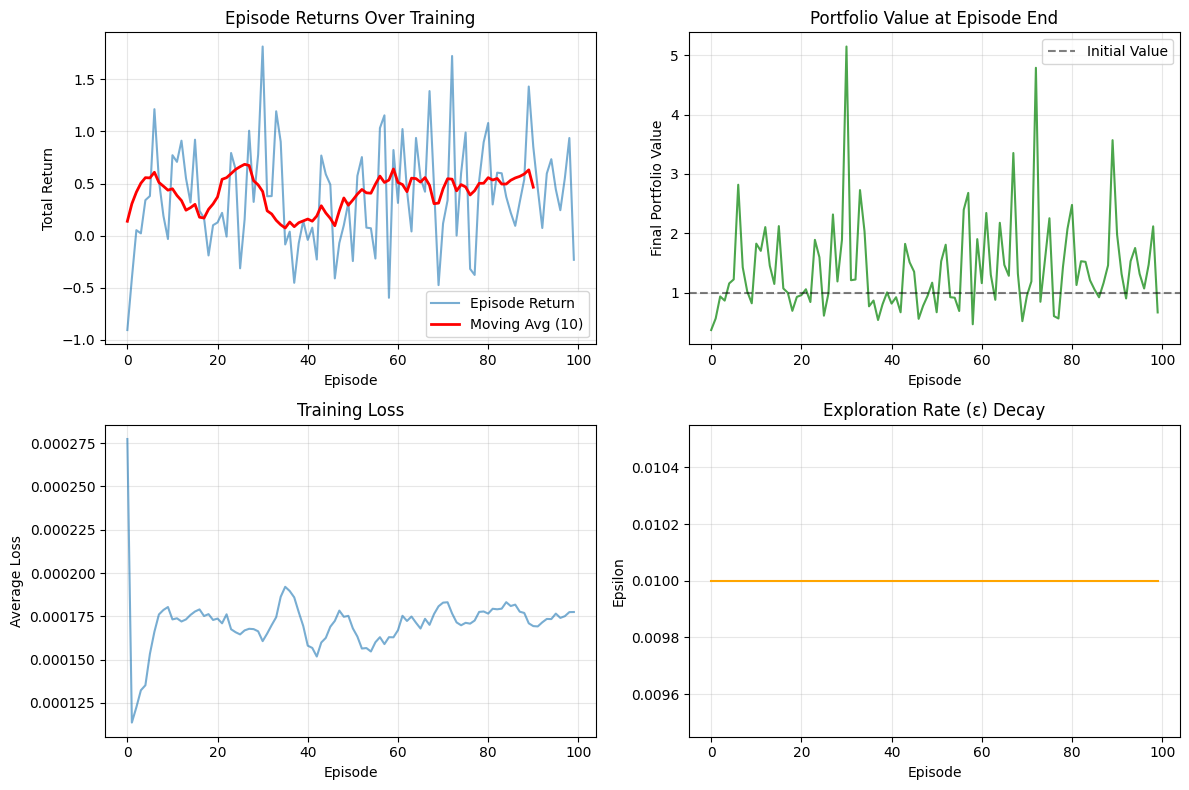


Final Statistics:
  Best Episode Return: 1.8155
  Best Portfolio Value: 5.1438
  Final Epsilon: 0.0100


In [13]:
# Visualize Training Results

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Episode Returns
ax1 = axes[0, 0]
ax1.plot(history['episode_returns'], alpha=0.6, label='Episode Return')
ax1.plot(np.convolve(history['episode_returns'], np.ones(10)/10, mode='valid'), 
         'r-', linewidth=2, label='Moving Avg (10)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Return')
ax1.set_title('Episode Returns Over Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Portfolio Value
ax2 = axes[0, 1]
ax2.plot(history['portfolio_values'], 'g-', alpha=0.7)
ax2.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Initial Value')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Final Portfolio Value')
ax2.set_title('Portfolio Value at Episode End')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Loss
ax3 = axes[1, 0]
ax3.plot(history['losses'], alpha=0.6)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Loss')
ax3.set_title('Training Loss')
ax3.grid(True, alpha=0.3)

# Epsilon
ax4 = axes[1, 1]
ax4.plot(history['epsilons'], 'orange')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Epsilon')
ax4.set_title('Exploration Rate (ε) Decay')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Statistics:")
print(f"  Best Episode Return: {max(history['episode_returns']):.4f}")
print(f"  Best Portfolio Value: {max(history['portfolio_values']):.4f}")
print(f"  Final Epsilon: {agent.epsilon:.4f}")

In [14]:
# Evaluate on Test Data

def evaluate_agent(agent: DQNAgent, env: SimpleTradingEnv) -> dict:
    """Evaluate trained agent (no exploration)."""
    state = env.reset()
    done = False
    total_return = 0
    actions_taken = []
    
    while not done:
        action = agent.select_action(state, training=False)
        actions_taken.append(action)
        state, reward, done, info = env.step(action)
        total_return += reward
    
    return {
        'total_return': total_return,
        'portfolio_value': env.portfolio_value,
        'actions': actions_taken,
        'trade_history': env.trade_history
    }

# Generate test data
np.random.seed(123)  # Different seed for test
test_prices = generate_price_series(500, trend=0.0001, volatility=0.015)
test_env = SimpleTradingEnv(test_prices)

# Evaluate
results = evaluate_agent(agent, test_env)

# Compare with buy-and-hold
buy_hold_return = (test_prices[-1] / test_prices[0]) - 1

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Agent Portfolio Value: {results['portfolio_value']:.4f}")
print(f"Agent Total Return: {results['total_return']*100:.2f}%")
print(f"Buy-and-Hold Return: {buy_hold_return*100:.2f}%")
print(f"\nAction Distribution:")
actions = np.array(results['actions'])
for i, name in enumerate(['Sell', 'Hold', 'Buy']):
    pct = (actions == i).sum() / len(actions) * 100
    print(f"  {name}: {pct:.1f}%")


TEST SET EVALUATION
Agent Portfolio Value: 0.7751
Agent Total Return: -19.95%
Buy-and-Hold Return: -24.44%

Action Distribution:
  Sell: 0.0%
  Hold: 0.0%
  Buy: 100.0%


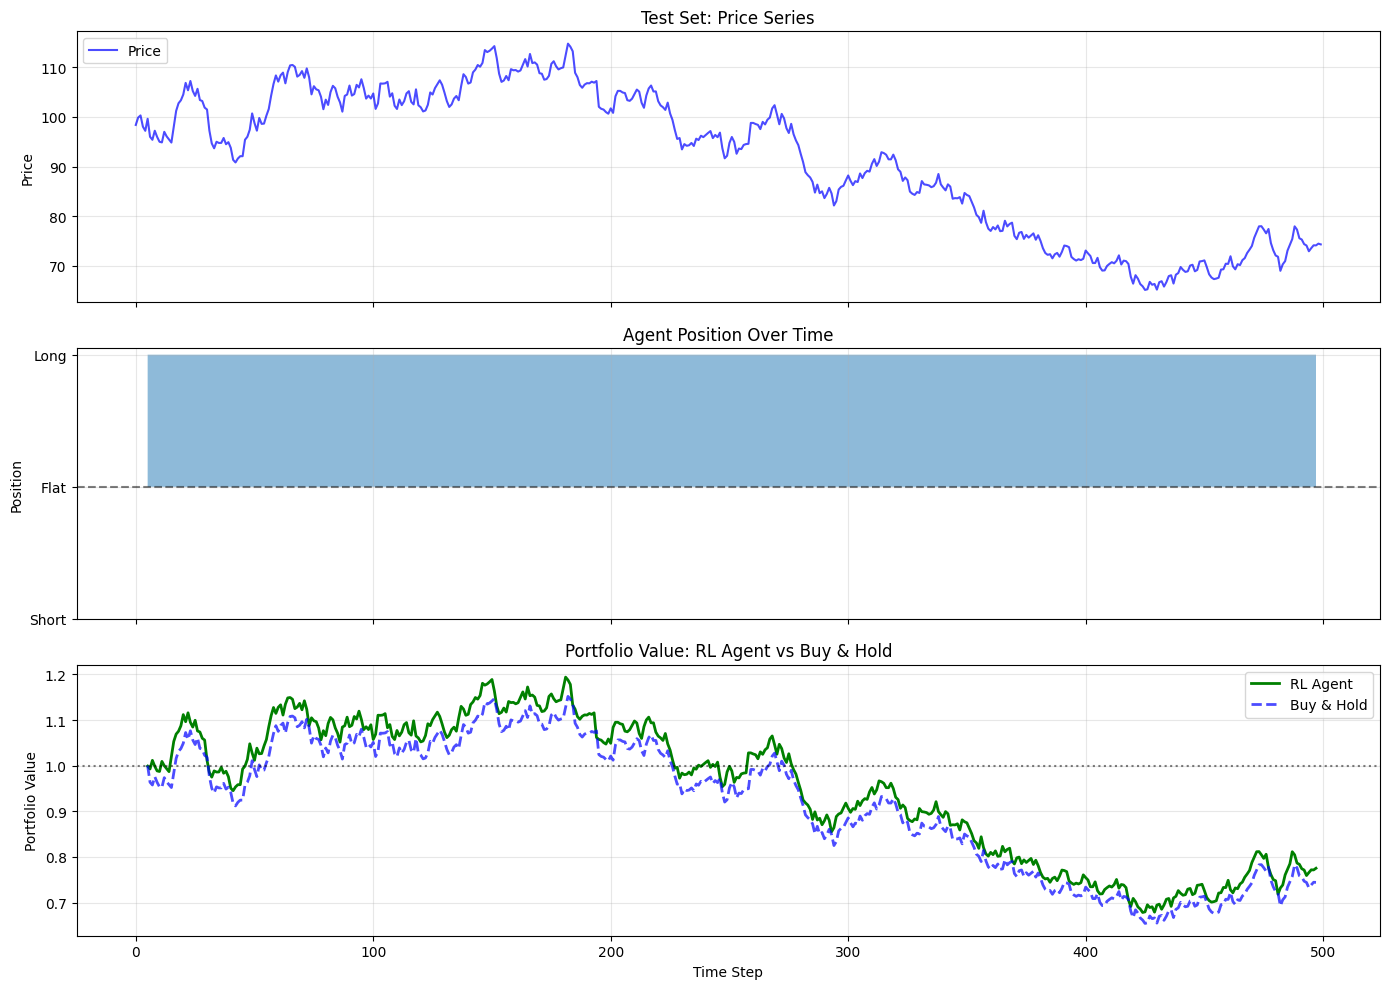

In [15]:
# Visualize Agent's Trading Behavior

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price and actions
ax1 = axes[0]
ax1.plot(test_prices, 'b-', label='Price', alpha=0.7)
ax1.set_ylabel('Price')
ax1.set_title('Test Set: Price Series')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Positions over time
ax2 = axes[1]
positions = [t['position'] for t in results['trade_history']]
steps = [t['step'] for t in results['trade_history']]
ax2.fill_between(steps, positions, alpha=0.5, step='mid')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_ylabel('Position')
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels(['Short', 'Flat', 'Long'])
ax2.set_title('Agent Position Over Time')
ax2.grid(True, alpha=0.3)

# Portfolio value vs buy-and-hold
ax3 = axes[2]
portfolio_values = [t['portfolio_value'] for t in results['trade_history']]
buy_hold_values = test_prices[test_env.lookback:test_env.lookback+len(portfolio_values)] / test_prices[test_env.lookback]

ax3.plot(steps, portfolio_values, 'g-', label='RL Agent', linewidth=2)
ax3.plot(steps, buy_hold_values, 'b--', label='Buy & Hold', linewidth=2, alpha=0.7)
ax3.axhline(y=1.0, color='k', linestyle=':', alpha=0.5)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Portfolio Value')
ax3.set_title('Portfolio Value: RL Agent vs Buy & Hold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 3: Week 16 Summary

## Key Concepts Covered This Week

### Day 1-2: RL Foundations
- **Markov Decision Process (MDP)**: States, actions, transitions, rewards
- **Value Functions**: V(s) and Q(s,a)
- **Bellman Equations**: Recursive relationship for optimal decisions
- **Policy vs Value**: Direct action mapping vs state/action evaluation

### Day 3-4: Deep Q-Learning
- **DQN Architecture**: Neural network for Q-function approximation
- **Experience Replay**: Break correlation, improve sample efficiency
- **Target Networks**: Stabilize training with delayed updates
- **Double DQN**: Reduce overestimation bias

### Day 5-6: Policy Gradients & Actor-Critic
- **REINFORCE**: Direct policy optimization
- **Advantage Functions**: Variance reduction
- **Actor-Critic**: Combine value and policy learning
- **PPO/A2C**: Modern policy gradient algorithms

### Day 7: Integration & Interview Prep
- **10 Interview Questions**: Core RL concepts for quant interviews
- **Mini-Project**: Complete DQN trading agent
- **Practical Challenges**: Non-stationarity, reward design, market impact

---

## Essential Formulas to Memorize

| Concept | Formula |
|---------|--------|
| Bellman (Q) | $Q^*(s,a) = R(s,a) + \gamma \sum_{s'} P(s'|s,a) \max_{a'} Q^*(s',a')$ |
| Q-Learning | $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$ |
| Policy Gradient | $\nabla_\theta J = \mathbb{E}[\nabla_\theta \log \pi_\theta(a|s) \cdot G_t]$ |
| Advantage | $A(s,a) = Q(s,a) - V(s)$ |
| TD Error | $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ |

---

## Trading-Specific RL Considerations

1. **State Design**:
   - Include position information
   - Normalize price features
   - Consider regime indicators

2. **Reward Engineering**:
   - Risk-adjusted returns (Sharpe-based)
   - Include transaction costs
   - Penalize excessive turnover

3. **Validation**:
   - Walk-forward testing
   - Multiple market regimes
   - Out-of-sample evaluation

4. **Deployment**:
   - Paper trading first
   - Position limits and risk controls
   - Continuous monitoring and retraining

In [16]:
# Quick Reference: Key RL Components for Trading

print("""
╔══════════════════════════════════════════════════════════════════╗
║           REINFORCEMENT LEARNING FOR TRADING CHEATSHEET          ║
╠══════════════════════════════════════════════════════════════════╣
║  ALGORITHM SELECTION:                                            ║
║  ├─ Discrete actions (Buy/Hold/Sell) → DQN, Double DQN           ║
║  ├─ Continuous actions (Position sizing) → PPO, SAC, DDPG        ║
║  └─ Multi-asset allocation → Multi-agent RL, MARL                ║
║                                                                  ║
║  KEY HYPERPARAMETERS:                                            ║
║  ├─ Learning rate: 1e-4 to 1e-3 (start lower for stability)      ║
║  ├─ Discount (γ): 0.95-0.99 (higher = more long-term)            ║
║  ├─ Epsilon decay: 0.99-0.999 (slower = more exploration)        ║
║  └─ Buffer size: 10K-100K (more = better sample diversity)       ║
║                                                                  ║
║  COMMON PITFALLS:                                                ║
║  ├─ Lookahead bias in state features                             ║
║  ├─ Ignoring transaction costs → unrealistic profits             ║
║  ├─ Overfitting to historical patterns                           ║
║  └─ Not accounting for market impact                             ║
║                                                                  ║
║  INTERVIEW TIPS:                                                 ║
║  ├─ Explain exploration-exploitation in trading context          ║
║  ├─ Discuss reward shaping and its risks                         ║
║  ├─ Know on-policy vs off-policy trade-offs                      ║
║  └─ Be ready to code Bellman update from scratch                 ║
╚══════════════════════════════════════════════════════════════════╝
""")

print("\n✅ Week 16 Complete! Ready for Week 17: Options & Deep Hedging")


╔══════════════════════════════════════════════════════════════════╗
║           REINFORCEMENT LEARNING FOR TRADING CHEATSHEET          ║
╠══════════════════════════════════════════════════════════════════╣
║  ALGORITHM SELECTION:                                            ║
║  ├─ Discrete actions (Buy/Hold/Sell) → DQN, Double DQN           ║
║  ├─ Continuous actions (Position sizing) → PPO, SAC, DDPG        ║
║  └─ Multi-asset allocation → Multi-agent RL, MARL                ║
║                                                                  ║
║  KEY HYPERPARAMETERS:                                            ║
║  ├─ Learning rate: 1e-4 to 1e-3 (start lower for stability)      ║
║  ├─ Discount (γ): 0.95-0.99 (higher = more long-term)            ║
║  ├─ Epsilon decay: 0.99-0.999 (slower = more exploration)        ║
║  └─ Buffer size: 10K-100K (more = better sample diversity)       ║
║                                                                  ║
║  COMMON PITFALLS:              